In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')
import multiprocessing
print("num of cpus:", multiprocessing.cpu_count())


num of cpus: 128


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#folder_path = '/content/drive/MyDrive/TDS_data_15000'
folder_path = './15K files/'
#Load and preprocess the data
def load_data(folder_path):
  data = {}
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      if os.path.isfile(file_path):
          with open(file_path, 'r') as file:
              df1 = pd.read_csv(file_path, header=None, names=['des_flux', 'detrap_en', 'def_conc'], index_col=None, squeeze = True)
              data[filename] = df1
    
              num_datapts = len(df1["des_flux"])
  # Combine all the data into a single dataframe
  df = pd.concat(data.values())

  return df, num_datapts

df, num_datapts = load_data(folder_path)

des_flux=df['des_flux']
des_flux=des_flux.tolist()
num_files=int(len(des_flux)/num_datapts) 
des_flux=np.reshape(des_flux, [num_files, num_datapts])
    # This assumes that all spectra in the dataset/folder have the same
    # amount of datapoints
print(type(des_flux[0]), des_flux.shape)

detrap_en=df['detrap_en']
detrap_en=detrap_en.dropna()
detrap_en=detrap_en.tolist()
num_files=int(len(detrap_en)/4)
detrap_en=np.reshape(detrap_en, [num_files, 4])


def_conc=df['def_conc']
def_conc=def_conc.dropna()
def_conc=def_conc.tolist()
num_files=int(len(def_conc)/4)
def_conc=np.reshape(def_conc, [num_files, 4])


def_param = np.concatenate([detrap_en, def_conc], axis=1)
def_param = np.log10(def_param) # transforming the targets
print(def_param.shape)

<class 'numpy.ndarray'> (15000, 301)
(15000, 8)


##### Manually adding features

Note that the features table only takes into account the global maximum and not any local max.


In [3]:
# Peak information
# Peak heights, position, and full width at half max
from scipy.signal import peak_widths, find_peaks, peak_prominences
from scipy.optimize import curve_fit
from sklearn.metrics import auc


peak_heights = []
fwhm = []
peak_positions = []
area_under_curves = []
stdev = []
peak_prom = []

for i in des_flux:
    peaks, _ = find_peaks(i)
    peak_pos = np.argmax(i)
    peak_height = np.max(i)
    peak_width, _, _, _ = peak_widths(i, [peak_pos], rel_height=0.5) 
        #taking only the first output (widths)
    prominence = np.max(peak_prominences(i, peaks)[0])
    peak_heights.append(peak_height)
    peak_prom.append(prominence)
    fwhm.append(peak_width[0])
    peak_positions.append(peak_pos)
# Area under curve
# Calculated using the trapezoidal method
    area_under_curve = auc(range(0,len(i)), i)
    area_under_curves.append(area_under_curve)
#STDEV
    spectra_std = np.std(i)
    stdev.append(spectra_std)


In [4]:
# PCA Components based on normalized spectra

# Standardizing and applying PCA using a pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))])

scaled_des_flux = pca_pipe.fit_transform(des_flux)
result_pca = pca_pipe.fit_transform(scaled_des_flux)


# Formatting them into columns in a df
pca_col = ['PCA Component {}'.format(i+1) for i in range(result_pca.shape[1])]
pca_df = pd.DataFrame(data=result_pca, columns=pca_col)

display(pca_df)

PCA Component 1  PCA Component 2  PCA Component 3  PCA Component 4  \
0            -1.831712        -0.099691         1.072351         1.319364   
1            -1.134966        -1.023512         1.412242         0.197393   
2            -0.777970         0.615698         0.042123        -0.005855   
3            -0.694220         0.559444        -0.224755         0.092674   
4            -0.307162         0.382054         0.148922        -0.574350   
...                ...              ...              ...              ...   
14995        -0.630853        -0.229937         1.097375        -0.697782   
14996         0.119883         1.118923        -0.904433        -0.391676   
14997         1.876701         0.743302         1.892684         1.761482   
14998         7.200142         2.359334         6.117691         9.133405   
14999        -1.064971         0.663470        -0.830439         0.528177   

       PCA Component 5  
0             0.992028  
1            -0.275637  
2            -0.113623  
3             0.719736  
4            -0.171816  
...                ...  
14995         1.064748  
14996        -2.041228  
14997        -1.948084  
14998         4.541179  
14999        -0.836578  

[15000 rows x 5 columns]

In [5]:
### Making the features matrix 
features_matrix = pd.DataFrame()
features_matrix['peak_heights'] = peak_heights 
features_matrix['peak_pos'] = peak_positions
features_matrix['fwhm'] = fwhm
features_matrix['peak prominences'] = peak_prom
features_matrix['auc'] = area_under_curves
features_matrix['std'] = stdev
features_matrix = pd.concat([features_matrix, pca_df],axis=1)
display(features_matrix)

peak_heights  peak_pos        fwhm  peak prominences           auc  \
0      1.104600e+19       139   62.925853      1.104600e+19  7.168618e+20   
1      8.952698e+18       108   76.863979      8.952698e+18  6.980819e+20   
2      6.449705e+18       135  118.976213      6.449705e+18  6.585460e+20   
3      6.255561e+18       150   99.830005      6.255561e+18  5.768126e+20   
4      3.924261e+18       109  155.580504      3.924261e+18  5.837127e+20   
...             ...       ...         ...               ...           ...   
14995  5.871478e+18       121   70.829252      5.871478e+18  4.089573e+20   
14996  8.661125e+18       207   75.580094      8.661125e+18  8.404429e+20   
14997  7.093851e+18        95   43.338462      7.093565e+18  9.985840e+20   
14998  7.871170e+18       242  122.573237      7.844419e+18  9.833929e+20   
14999  8.160443e+18       187  120.227547      8.160443e+18  8.374144e+20   

                std  PCA Component 1  PCA Component 2  PCA Component 3  \
0      3.670862e+18        -1.831712        -0.099691         1.072351   
1      3.100856e+18        -1.134966        -1.023512         1.412242   
2      2.208307e+18        -0.777970         0.615698         0.042123   
3      2.134721e+18        -0.694220         0.559444        -0.224755   
4      1.634831e+18        -0.307162         0.382054         0.148922   
...             ...              ...              ...              ...   
14995  1.928194e+18        -0.630853        -0.229937         1.097375   
14996  2.822632e+18         0.119883         1.118923        -0.904433   
14997  2.359050e+18         1.876701         0.743302         1.892684   
14998  2.465215e+18         7.200142         2.359334         6.117691   
14999  2.881918e+18        -1.064971         0.663470        -0.830439   

       PCA Component 4  PCA Component 5  
0             1.319364         0.992028  
1             0.197393        -0.275637  
2            -0.005855        -0.113623  
3             0.092674         0.719736  
4            -0.574350        -0.171816  
...                ...              ...  
14995        -0.697782         1.064748  
14996        -0.391676        -2.041228  
14997         1.761482        -1.948084  
14998         9.133405         4.541179  
14999         0.528177        -0.836578  

[15000 rows x 11 columns]

##### Gaussian Fitting

By Gaussian peak fitting to two peaks (the two most prominent spectroscopic peaks), similar to https://www.mdpi.com/1996-1944/13/23/5500, we can avoid generalizing to the global max. 

*The following curve fitting does not work, unfortunately. Please skip this section.* 

The fitted peaks would likely be its own training data set, since the fitted data will be similar to the raw data in format.

In [6]:
# Defining the gaussian function  
from scipy.optimize import curve_fit

def guass_params(y):
    # peak 1
    # parameters to calculate the gaussian
    x = np.arange(len(y))
    center = np.argmax(y)
    y_peak1 = y[center - 60:center + 60]
    stdev = np.std(y_peak1)
    amp = max(y) - min(y)

    indices, peak_dict = find_peaks(y, height=(None, None))
    heights = peak_dict['peak_heights']

    if len(indices) < 2:
        return x, amp, center, stdev, 0, 0, 0  # returns zeroes if there is no 2nd peak found
    # peak 2
    sorted_peak_indices = np.argsort(peak_dict['peak_heights'])
    center2 = indices[sorted_peak_indices[-2]]
    y_peak2 = y[center2 - 60:center2 + 60]
    stdev2 = np.std(y_peak2)
    amp2 = heights[sorted_peak_indices[-2]] - min(y)
    
    return x, amp, center, stdev, amp2, center2, stdev2

def gauss2(x, amp, center, stdev, amp2, center2, stdev2):
    '''
    Function for gaussian function to be used in Scipy.curve_fit.
    Calculates fitting for overlapping peaks (the highest peak and 
    the second highest peak) by taking the sum of both gaussians.
    '''
    if amp2 == 0 and center2 == 0 and stdev2 == 0:
        return amp * np.exp(-((x - center) ** 2) / (2 * stdev ** 2))
    
    return amp * np.exp(-((x - center) ** 2) / (2 * stdev ** 2))  + amp2 * np.exp(-((x - center2) ** 2) / (2 * stdev2 ** 2))

def gauss_fit_curve(y, popt):
    x = np.arange(len(y))
    amp_opt, center_opt, stdev_opt, amp2_opt, center2_opt, stdev2_opt = popt
    y_fit = gauss2(x, amp_opt, center_opt, stdev_opt, amp2_opt, center2_opt, stdev2_opt)
    return y_fit.tolist()




In [ ]:
import matplotlib.pyplot as plt
y_fit = [] # storing the fitted data to use as an option for training data 
for i in des_flux:
    x, amp, center, stdev, amp2, center2, stdev2 = guass_params(i)
    temps = np.linspace(300,1200,301)
    popt, _ = curve_fit(gauss2, temps, i,p0=((4.0E18, 600, 1.5E18, 1E18, 900, 2.0E18))) # added random guesses to avoid 
    
    fitted = gauss_fit_curve(i,popt)
    y_fit.append(fitted)
plt.plot(temps, des_flux[6], 'r',label='Training Data') 
plt.plot(temps, y_fit[6], 'b',label='Fitted Curve')

# Produces curves that are straight lines :(

### Raw 0.3K/s, 15K dataset (Smoothed)

In [6]:
### Preparing the raw data
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


# Split the data into train and test sets
X_train, X_test= train_test_split(des_flux, test_size=0.1, random_state=42)
y_train_raw, y_test_raw = train_test_split(def_param, test_size=0.1, random_state=42)

# Normalize the data using StandardScaler 
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_norm = scaler.fit_transform(np.array(X_train).reshape(-1, num_datapts)) # Change lists into array
X_test_norm = scaler.transform(np.array(X_test).reshape(-1, num_datapts))

X_train_transform_raw = np.reshape(X_train_norm, (X_train_norm.shape[0], -1))
X_test_transform_raw = np.reshape(X_test_norm, (X_test_norm.shape[0], -1))

print(X_train_transform_raw.shape)
print(X_test_transform_raw.shape)



(13500, 301)
(1500, 301)


##### Hyperparameter search

Instead of using sklearn's hyperparameter tuning, we can perform hyperparameter optimization using based on the Bayes Theorem. Using the `hyperopt` package for hyperparameter optimization, comparable loss scores and better performance time compared to `GridSearchCV` has been achieved:
https://doi.org/10.11989/JEST.1674-862X.80904120
http://jmlr.org/proceedings/papers/v28/bergstra13.html

Documentation: http://hyperopt.github.io/hyperopt/

Parameter searching in `hyperopt` has a high level of customization. For example, defining the parameter grid can be done using two methods:
- `hp.choice`: Analogous to RandomizedSearchCV from sk-learn, randomly selects from a search space. 
- `hp.randint`: Analogous to GridSearchCV, iteratively and exhaustively searches within a range. 

In [8]:
#pip install hyperopt

In [8]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error

# Function to be optimized (check the hyperopt doc)
def objective(params):
    rfr = RandomForestRegressor(**params,random_state=42)
    scores = cross_val_score(rfr, X_train_transform_raw, y_train_raw, cv=5, scoring='neg_mean_squared_error')
    mse = -scores.mean()

    return mse

# Define param grid
space = {
#     'n_estimators': hp.randint('n_estimators', 100, 201),
#     'max_depth': hp.randint('max_depth', 1, 15),
    'n_estimators': hp.choice('n_estimators', range(100, 201)),
    'max_depth': hp.choice('max_depth', range(1, 15)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 20)),
    'max_features': hp.choice('max_features', ["sqrt", "log2"])}

In [9]:
%%time
# Bayesian Optimization using the TPE algorithm `tpe` 
# TPE is sequential-based and balances "explore vs exploit" when 
# searching for hyperparameters: 

rstate = np.random.default_rng(42)
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials, rstate = rstate)

# best hyperparameters and best score
best_params = space_eval(space, best)
best_score = min(trials.losses())

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Running with `hp.randint` and `hp.choice` both resulted in the same hyperparameters

100%|██████████| 100/100 [1:38:08<00:00, 58.89s/trial, best loss: 0.05311838855354843]
Best Parameters: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 199}
Best Score: 0.05311838855354843
CPU times: user 1h 37min 14s, sys: 3.11 s, total: 1h 37min 17s
Wall time: 1h 38min 8s


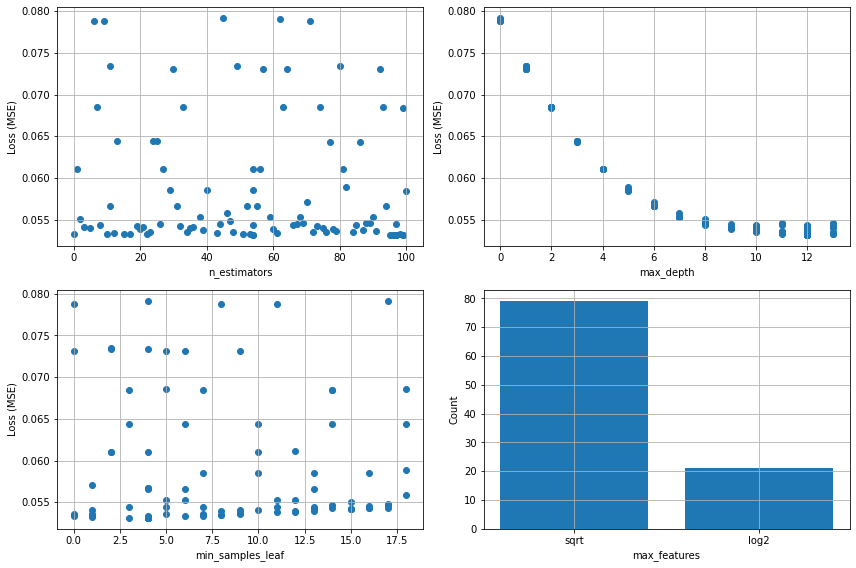

In [11]:
import matplotlib.pyplot as plt

# Extracting hyperparameters
hyperparams = [trial['misc']['vals'] for trial in trials.trials]
losses = [trial['result']['loss'] for trial in trials.trials]


n_estimators = [params['n_estimators'] for params in hyperparams]
max_depth = [params['max_depth'] for params in hyperparams]
min_samples_leaf = [params['min_samples_leaf'] for params in hyperparams]
max_features = [params['max_features'] for params in hyperparams]

# Plotting hyperparameter vs loss
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].scatter(n_estimators, losses)
axs[0, 0].set_xlabel('n_estimators')
axs[0, 0].set_ylabel('Loss (MSE)')
axs[0, 0].grid(True)

axs[0, 1].scatter(max_depth, losses)
axs[0, 1].set_xlabel('max_depth')
axs[0, 1].set_ylabel('Loss (MSE)')
axs[0, 1].grid(True)

axs[1, 0].scatter(min_samples_leaf, losses)
axs[1, 0].set_xlabel('min_samples_leaf')
axs[1, 0].set_ylabel('Loss (MSE)')
axs[1, 0].grid(True)

unique_max_features = np.unique(max_features)
feature_labels = ['sqrt', 'log2']
feature_values = [max_features.count(f) for f in unique_max_features]

axs[1, 1].bar(feature_labels, feature_values)
axs[1, 1].set_xlabel('max_features')
axs[1, 1].set_ylabel('Count')
axs[1, 1].grid(True)

fig.tight_layout()
fig.show()


In [9]:
### Non-transformed trial:
# 100%|██████████| 100/100 [47:14<00:00, 28.35s/trial, best loss: 0.003159586913488544]
# Best Parameters: {'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 267}
# Best Score: 0.003159586913488544
# CPU times: user 47min 4s, sys: 2.93 s, total: 47min 7s
# Wall time: 47min 15s

# Performing a log transformation on the target variables increases loss error by a factor of 10

In [12]:
### Predicting Parameters
# Uncomment and save the best_params manually without having to rerun the search

# best_params = {
#     'n_estimators': 199,
#     'max_depth': 13,
#     'min_samples_leaf': 5,
#     'max_features': 'sqrt'}

rfr_best_raw = RandomForestRegressor(**best_params, random_state=42)
rfr_best_raw.fit(X_train_transform_raw, y_train_raw)

y_pred_raw = rfr_best_raw.predict(X_test_transform_raw)

mse = mean_squared_error(y_test_raw, y_pred_raw)
print(mse)


0.053711280846166845


### Features Model

In [13]:
### Preparing the featurized data

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


# Split the data into train and test sets
X_train, X_test= train_test_split(features_matrix, test_size=0.1, random_state=42)
y_train_feat, y_test_feat = train_test_split(def_param, test_size=0.1, random_state=42)

# Normalize the data using StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_norm_feat = scaler.fit_transform(X_train)
X_test_norm_feat = scaler.transform(X_test)

# print(X_train_norm_feat.shape)
# print(X_test_norm_feat.shape)

In [14]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error

def objective(params):
    rfr = RandomForestRegressor(**params,random_state=42)
    scores = cross_val_score(rfr, X_train_norm_feat, y_train_feat, cv=5, scoring='neg_mean_squared_error')
    mse = -scores.mean()

    return mse

# Define param grid
space = {
#     'n_estimators': hp.randint('n_estimators', 100, 201),
#     'max_depth': hp.randint('max_depth', 1, 15),
    'n_estimators': hp.randint('n_estimators', 100, 200),
    'max_depth': hp.randint('max_depth', 1, 15),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 20)),
    'max_features': hp.choice('max_features', ["sqrt", "log2"])}

In [15]:
%%time
# searching for hyperparameters: 
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials, rstate = np.random.default_rng(42))

# best hyperparameters and best score
best_params = space_eval(space, best)
best_score = min(trials.losses())

print("Best Parameters:", best_params)
print("Best Score:", best_score)

100%|██████████| 100/100 [22:56<00:00, 13.76s/trial, best loss: 0.05897584804946158]
Best Parameters: {'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 7, 'n_estimators': 195}
Best Score: 0.05897584804946158
CPU times: user 22min 44s, sys: 748 ms, total: 22min 45s
Wall time: 22min 56s


In [ ]:
# Non log-transformed training using only hp.choice:
# 100%|██████████| 100/100 [15:19<00:00,  9.19s/trial, best loss: 0.004580962113038334]
# Best Parameters: {'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 387}
# Best Score: 0.004580962113038334
# CPU times: user 15min 8s, sys: 8.78 s, total: 15min 16s
# Wall time: 15min 19s


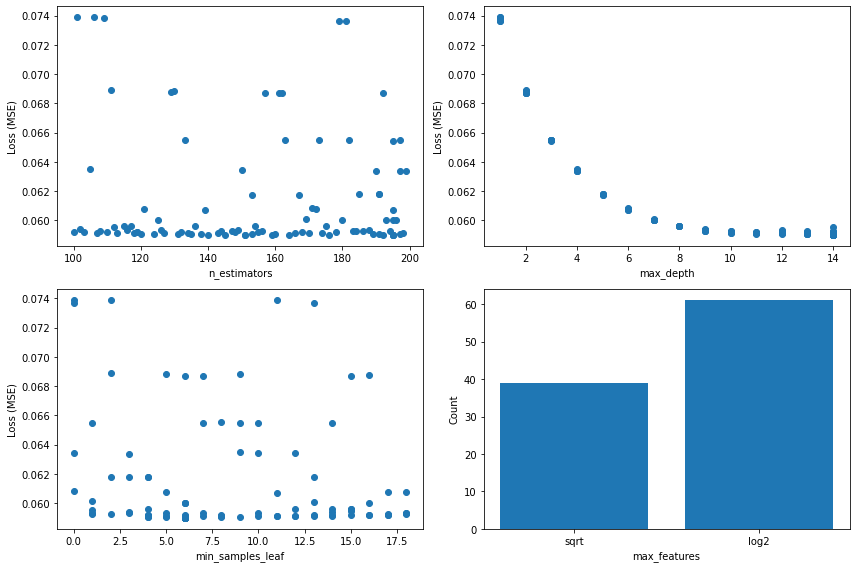

In [17]:
# Extracting hyperparameters
hyperparams = [trial['misc']['vals'] for trial in trials.trials]
losses = [trial['result']['loss'] for trial in trials.trials]


n_estimators = [params['n_estimators'] for params in hyperparams]
max_depth = [params['max_depth'] for params in hyperparams]
min_samples_leaf = [params['min_samples_leaf'] for params in hyperparams]
max_features = [params['max_features'] for params in hyperparams]

# Plotting hyperparameter vs loss
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].scatter(n_estimators, losses)
axs[0, 0].set_xlabel('n_estimators')
axs[0, 0].set_ylabel('Loss (MSE)')

axs[0, 1].scatter(max_depth, losses)
axs[0, 1].set_xlabel('max_depth')
axs[0, 1].set_ylabel('Loss (MSE)')

axs[1, 0].scatter(min_samples_leaf, losses)
axs[1, 0].set_xlabel('min_samples_leaf')
axs[1, 0].set_ylabel('Loss (MSE)')

unique_max_features = np.unique(max_features)
feature_labels = ['sqrt', 'log2']
feature_values = [max_features.count(f) for f in unique_max_features]

axs[1, 1].bar(feature_labels, feature_values)
axs[1, 1].set_xlabel('max_features')
axs[1, 1].set_ylabel('Count')

fig.tight_layout()
fig.show()


In [18]:
### Predicting Parameters
# Saving the best_params manually without having to rerun the search.

best_params = {
    'n_estimators': 195,
    'max_depth': 14,
    'min_samples_leaf': 7,
    'max_features': 'log2'}

rfr_best_feat = RandomForestRegressor(**best_params, random_state=42)
rfr_best_feat.fit(X_train_norm_feat, y_train_feat)

y_pred_feat = rfr_best_feat.predict(X_test_norm_feat)

mse = mean_squared_error(y_test_feat, y_pred_feat)
print(mse)


0.059658384655006155


##### Feature Importances

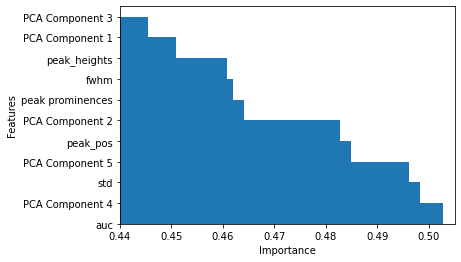

In [24]:
import matplotlib.pyplot as plt
importances = rfr_best_feat.feature_importances_
feat_names = features_matrix.columns

sort_ind = np.argsort(importances)[::-1]
sort_imp = importances[sort_ind]
sort_names = feat_names[sort_ind]

# Plotting feature importances
plt.bar(sort_imp,range(len(sort_imp)))
plt.yticks(range(len(sort_imp)), sort_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.xlim(0.44, 0.505)
plt.show()

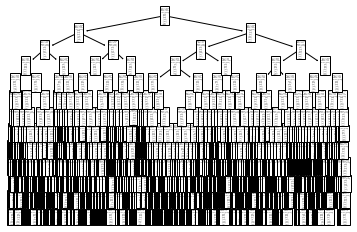

In [17]:
from sklearn.tree import plot_tree
plot_tree(rfr_best_feat.estimators_[0])

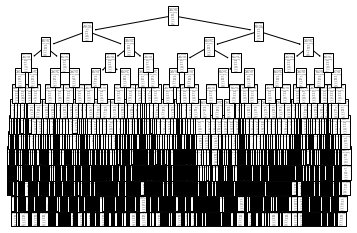

In [16]:
plot_tree(rfr_best_raw.estimators_[0])

Default tree plotting is hard to read, check the bottom of the notebook for representations using graphviz.

##### Model Blending

In [12]:
# Combining the predictions by averaging them. 
# There are other methods for model blending/stacking but
# for now, let's take the averages.
combined_pred = (y_pred_feat + y_pred_raw) / 2
mse = mean_squared_error(y_test_raw, combined_pred)
print(mse)

0.05547382763925744


##### Plotting Predictions

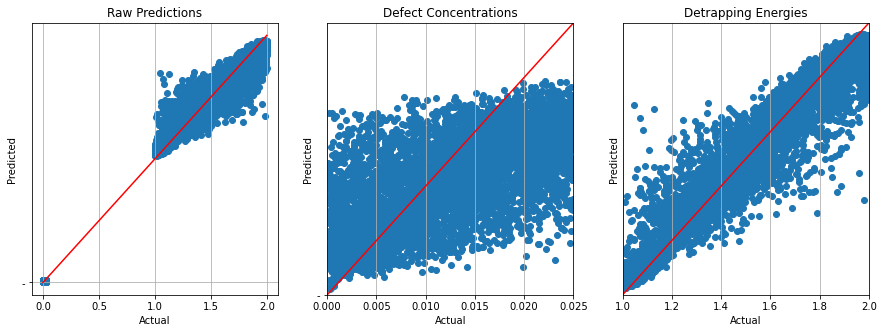

In [15]:
import matplotlib.pyplot as plt

def plot_pred(y_test, y_pred, title):
    y_test = 10 ** y_test
    y_pred = 10 ** y_pred   
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.scatter(y_test, y_pred)
    ax1.plot([0, 2], [0, 2], 'r', '-')
    ax1.set_xlabel('Actual')
    ax1.set_ylabel('Predicted')
    ax1.set_title(title)
    ax1.grid(True)
    
    ax2.scatter(y_test, y_pred)
    ax2.plot([0, 0.025], [0, 0.025], 'r', '-')
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted')
    ax2.set_xlim(0, 0.025)
    ax2.set_ylim(0, 0.025)
    ax2.set_title('Defect Concentrations')
    ax2.grid(True)

    ax3.scatter(y_test, y_pred)
    ax3.plot([1, 2], [1, 2], 'r', '-')
    ax3.set_xlabel('Actual')
    ax3.set_ylabel('Predicted')
    ax3.set_title('Detrapping Energies')
    ax3.set_xlim(1, 2)
    ax3.set_ylim(1, 2)
    ax3.grid(True)

plot_pred(y_test_raw,y_pred_raw, 'Raw Predictions')  

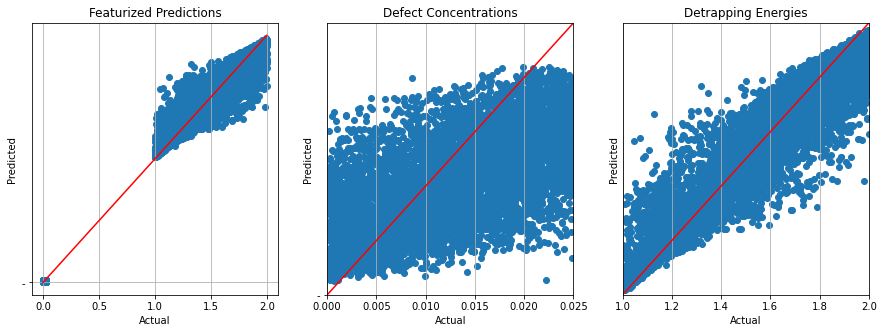

In [16]:
plot_pred(y_test_feat,y_pred_feat, 'Featurized Predictions')  

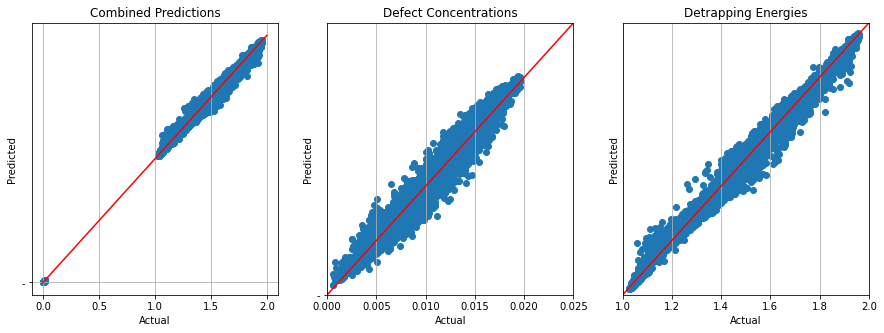

In [30]:
plot_pred(y_pred_raw,combined_pred,'Combined Predictions')

### Predicting Based on the Ground Truth

In [ ]:
#pip install spectrapepper

In [61]:
import spectrapepper as spep
from scipy import signal
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading ground truth data into a dataframe
folder_path = './Ground Truth Smoothed'
data = {}
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path) and file_path.endswith('.csv'):
        with open(file_path, 'r') as file:
            expt_df = pd.read_csv(file_path, header=None, names=['K', 'des_flux'], index_col=None, squeeze = True)
            expt_tds = expt_df.iloc[:, 1].values
            expt_datapts = len(expt_df["des_flux"])
            data[filename] = expt_df    

df = pd.concat(data.values())


expt_des_flux=df['des_flux']
expt_des_flux=expt_des_flux.tolist()
expt_files=int(len(expt_des_flux)/expt_datapts) 
expt_des_flux=np.reshape(expt_des_flux, [expt_files, expt_datapts])

display(len(expt_des_flux[1]))


902

##### GT Raw predictions

In [62]:

expt_pred_raw = []
for i in range(0,14):
    x_expt = np.array(expt_des_flux[i])
    x_expt = x_expt[0::3].reshape(1, -1)

    X_expt_norm = scaler.fit_transform(x_expt)
    X_expt_norm = scaler.transform(X_expt_norm)
    X_test_transform = np.reshape(X_expt_norm, (X_expt_norm.shape[0], -1))

    y_expt_pred = rfr_best_raw.predict(X_test_transform)

    y_expt_pred = np.reshape(y_expt_pred, (8, 1))
    pred_params = pd.DataFrame({'detrap_en':10 ** y_expt_pred[:4,0],
                                'defect_con':10 ** y_expt_pred[4:,0]}) # Inverse log transform

    display(f"Ground Truth {i+1}:", pred_params)
    expt_pred_raw.append(y_expt_pred)
    
    y = x_expt.flatten()
    x = np.linspace(300,1200,301)

    peak_pos = np.argmax(x_expt)
    peak_value = y[peak_pos]
    print(peak_pos, peak_value)
    
    ## Exporting as .csv
    src_path  = r'./log/raw_param/predict_params.csv'
    p = Path(src_path).parent.joinpath(f"raw_pred_params_{i+1}.csv")
    pred_params.to_csv(p, index=False)

'Ground Truth 1:'

detrap_en  defect_con
0   1.118635    0.002003
1   1.366535    0.001823
2   1.544961    0.001473
3   1.767930    0.001214

152 4.764666666666666e+16


'Ground Truth 2:'

detrap_en  defect_con
0   1.124941    0.001979
1   1.371263    0.001832
2   1.550385    0.001473
3   1.771399    0.001203

183 4.198666666666667e+17


'Ground Truth 3:'

detrap_en  defect_con
0   1.116161    0.001956
1   1.364201    0.001738
2   1.546452    0.001429
3   1.767737    0.001260

188 1.684e+17


'Ground Truth 4:'

detrap_en  defect_con
0   1.120283    0.001947
1   1.366515    0.001818
2   1.545915    0.001485
3   1.767525    0.001208

192 3.017333333333333e+17


'Ground Truth 5:'

detrap_en  defect_con
0   1.124362    0.002035
1   1.366780    0.001830
2   1.545369    0.001470
3   1.767260    0.001207

194 2.658e+17


'Ground Truth 6:'

detrap_en  defect_con
0   1.114640    0.002003
1   1.363277    0.001764
2   1.544271    0.001450
3   1.766625    0.001241

183 2.367333333333333e+17


'Ground Truth 7:'

detrap_en  defect_con
0   1.136385    0.002080
1   1.379246    0.001858
2   1.556473    0.001447
3   1.774871    0.001180

127 6.932e+17


'Ground Truth 8:'

detrap_en  defect_con
0   1.124905    0.002066
1   1.369454    0.001804
2   1.547300    0.001454
3   1.769280    0.001221

128 3.464666666666667e+17


'Ground Truth 9:'

detrap_en  defect_con
0   1.119924    0.002021
1   1.368943    0.001765
2   1.547590    0.001411
3   1.769520    0.001191

166 7.518666666666667e+16


'Ground Truth 10:'

detrap_en  defect_con
0   1.136385    0.002080
1   1.379246    0.001858
2   1.556473    0.001447
3   1.774871    0.001180

195 2.435333333333333e+17


'Ground Truth 11:'

detrap_en  defect_con
0   1.119144    0.001932
1   1.367646    0.001795
2   1.547052    0.001464
3   1.768443    0.001224

178 1.8546666666666662e+17


'Ground Truth 12:'

detrap_en  defect_con
0   1.115550    0.001916
1   1.365296    0.001761
2   1.545791    0.001472
3   1.768392    0.001220

127 1.0526666666666666e+18


'Ground Truth 13:'

detrap_en  defect_con
0   1.121639    0.001961
1   1.371012    0.001797
2   1.549820    0.001461
3   1.770411    0.001193

156 1.124e+17


'Ground Truth 14:'

detrap_en  defect_con
0   1.132265    0.002068
1   1.375968    0.001805
2   1.555309    0.001444
3   1.774590    0.001190

126 4.756e+17


##### GT Features Predictions

In [63]:
peak_heights = []
fwhm = []
peak_positions = []
area_under_curves = []
stdev = []
peak_prom = []

for i in expt_des_flux:    
# Peak information
# Peak heights, position, prominence, and full width at half max
    peaks, _ = find_peaks(i)
    peak_pos = np.argmax(i)
    peak_height = np.max(i)
    peak_width, _, _, _ = peak_widths(i, [peak_pos], rel_height=0.5) 
    peak_heights.append(peak_height)
    fwhm.append(peak_width[0])
    peak_positions.append(peak_pos)    
    prominence = np.max(peak_prominences(i, peaks)[0])
    peak_prom.append(prominence)

    
# Area under curve
# Calculated using the trapezoidal method
    area_under_curve = auc(range(0,len(i)), i)
    area_under_curves.append(area_under_curve)
# STDEV
    spectra_std = np.std(i)
    stdev.append(spectra_std)
    
pca_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))])

scaled_expt_des = pca_pipe.fit_transform(expt_des_flux)
result_pca = pca_pipe.fit_transform(scaled_expt_des)


# Formatting them into columns in a df
pca_col = ['PCA Component {}'.format(i+1) for i in range(result_pca.shape[1])]
pca_df = pd.DataFrame(data=result_pca, columns=pca_col)

### Making the features matrix 
features_matrix = pd.DataFrame()
features_matrix['peak_heights'] = peak_heights 
features_matrix['peak_pos'] = peak_positions
features_matrix['fwhm'] = fwhm
features_matrix['peak prominences'] = peak_prom
features_matrix['std'] = stdev
features_matrix['auc'] = area_under_curves
features_matrix = pd.concat([features_matrix, pca_df],axis=1)
display(features_matrix)

peak_heights  peak_pos        fwhm  peak prominences           std  \
0   4.768667e+16       454  290.162302      4.621400e+16  1.638158e+16   
1   4.199333e+17       548  174.494174      4.186840e+17  1.384690e+17   
2   1.685333e+17       568  161.047106      1.681642e+17  5.372150e+16   
3   3.017333e+17       576  202.024550      3.009301e+17  1.001815e+17   
4   2.658667e+17       581  210.426077      2.651354e+17  8.937861e+16   
5   2.367333e+17       549  221.706953      2.361737e+17  8.455735e+16   
6   6.932000e+17       380  324.911173      6.924385e+17  2.459532e+17   
7   3.464667e+17       383  313.634003      3.456960e+17  1.257978e+17   
8   7.526667e+16       497  209.625626      7.475715e+16  2.516947e+16   
9   2.436000e+17       586  257.656037      2.427514e+17  8.226860e+16   
10  1.854667e+17       534  347.392095      1.845619e+17  7.335256e+16   
11  1.052667e+18       380  326.036022      1.052022e+18  3.831497e+17   
12  1.124000e+17       466  329.826095      1.112978e+17  4.123851e+16   
13  4.756000e+17       378  341.862263      4.747071e+17  1.767816e+17   

             auc  PCA Component 1  PCA Component 2  PCA Component 3  \
0   1.514390e+19        -0.518769        -0.881941         0.007699   
1   7.686186e+19         1.959759        -0.155072        -1.713962   
2   2.813385e+19         1.417176        -0.613740         0.485670   
3   6.631249e+19        -1.905566        -0.466775        -1.467278   
4   6.013363e+19        -1.456097        -0.503190        -1.195071   
5   5.292533e+19         0.706442        -0.437093        -0.530195   
6   1.972324e+20        -0.184394         1.347879         0.224946   
7   9.758620e+19         0.736971         0.039784        -0.042425   
8   1.604650e+19        -0.051369        -0.812088         1.474981   
9   5.808884e+19        -0.339982        -0.210846         2.030265   
10  5.973487e+19         0.271199        -0.337203         0.152522   
11  3.122659e+20         0.134121         2.915443        -0.217357   
12  3.296914e+19         0.138907        -0.655642         0.054864   
13  1.445679e+20        -0.908398         0.770481         0.735341   

    PCA Component 4  PCA Component 5  
0         -1.439910         1.711083  
1          0.928844         1.326349  
2         -0.011983        -1.458818  
3          0.699881        -0.526400  
4          0.597742        -0.654123  
5          0.474854        -1.324863  
6         -0.159073         0.224882  
7         -0.550338        -0.039430  
8         -0.601557        -1.503344  
9          2.655199         1.148593  
10        -0.800879         0.403270  
11        -0.008417        -0.472958  
12        -0.798466         0.699851  
13        -0.985898         0.465907

In [59]:
# Predicting based on features and combining predictions
scaler.fit(X_train)
norm_feat_mat = scaler.transform(features_matrix)
expt_pred_feat = rfr_best_feat.predict(norm_feat_mat)
expt_pred_raw = np.array(expt_pred_raw).reshape(14,8)

combined_expt_pred = ( expt_pred_feat + expt_pred_raw ) / 2

In [64]:
# Exporting
for num, i in enumerate(expt_pred_feat):
    pred_params = pd.DataFrame({'detrap_en':10 ** i[:4],
                                'defect_con':10 ** i[4:]}) # Inverse log transform

    src_path  = r'./log/feat_param/predict_params.csv'
    p = Path(src_path).parent.joinpath(f"feat_pred_params_{num+1}.csv")
    pred_params.to_csv(p, index=False)


for num, i in enumerate(combined_expt_pred):
    pred_params = pd.DataFrame({'detrap_en':10 ** i[:4],
                                'defect_con':10 ** i[4:]}) # Inverse log transform

    src_path  = r'./log/combined/predict_params.csv'
    p = Path(src_path).parent.joinpath(f"combined_pred_params_{num+1}.csv")
    pred_params.to_csv(p, index=False)
    

#### Graphviz Trees
More readable than sk-learn `plot_tree`, but the rendered graph is too big to be displayed in an ipython notebook. 
Scroll to the right to see the rest of the plot.

In [32]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(rfr_best_feat.estimators_[0], out_file=None, 
                                feature_names=feat_names,  
                                class_names=['detrap_en','def_conc'],
                                filled=True, rotate=False)

graph = graphviz.Source(dot_data, format="png") 
graph.format = "png"
graph.render("rep_desc_tree")
graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.498107 to fit


In [35]:
dot_data = export_graphviz(rfr_best_raw.estimators_[0], out_file=None, 
                                feature_names=range(0,301),  
                                class_names=['detrap_en','def_conc'],
                                filled=True, rotate=False) # using the index number as the feature name

graph = graphviz.Source(dot_data, format="png") 
graph.format = "png"
graph.render("raw_rep_desc_tree")
graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.307014 to fit


In [39]:
import pickle

model_filename = 'rfr_feat.pkl'
pickle.dump(rfr_best_feat, open(model_filename, 'wb'))

model_filename = 'rfr_raw.pkl'
pickle.dump(rfr_best_raw, open(model_filename, 'wb'))